In [1]:
import json
import pandas as pd
from utils import preprocessing, set_index
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import clone_model 
from dc_vae_continual import DCVAE, Sampling
from utils import samples_conditions_embedd
import pickle
from statsmodels.graphics.tsaplots import plot_acf

2023-06-17 19:41:39.041361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def likelihood_norm(x, mu, sigma):
    return (np.exp(-0.5*((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma))/(1/(np.sqrt(2*np.pi)*sigma))

### Settings

In [3]:
settings_path = 'settings/model_settings_continual.txt'
settings = json.load(open(settings_path, 'r'))
print(settings)

{'dataset_name': 'TELCO', 'model_name': 'dc-vae_continual', 'scale': False, 'wo_outliers': True, 'max_std': 7, 'T': 128, 'M': 12, 'cnn_units': [64, 128, 128, 128, 128, 128, 64], 'dil_rate': [1, 2, 4, 8, 16, 32, 64], 'kernel': 2, 'strs': 1, 'activation': 'selu', 'alpha_reg': 0.0001, 'batch_size': 32, 'J': 64, 'epochs': 200, 'lr': 0.0001, 'lr_decay': False, 'decay_rate': 0.96, 'decay_step': 7000, 'val_percent': 0.2, 'time_embedding': False, 'summary': True, 'save_best_model': False, 'save_complete_model': True}


### Data

In [4]:
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_train = ["TELCO_data_2021_11.zip", "TELCO_data_2021_12.zip"]
files_train = [path+ i for i in filenames_train]

# Load data and predictions
# Read CSV files from List
data_train = pd.concat(map(pd.read_csv, files_train))
data_train = set_index(data_train)
data_train = preprocessing(data_train, flag_scaler=False, outliers=True)
data_train.head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12
time,,,,,,,,,,,,
2021-11-01 00:00:00,0.456788,0.361119,0.427533,0.821416,0.440503,0.433320,0.478866,0.482249,0.087843,0.35,0.052165,0.053619
2021-11-01 00:05:00,0.463067,0.361322,0.427533,0.693646,0.448490,0.442270,0.367807,0.393491,0.087843,0.35,0.052165,0.053619
2021-11-01 00:10:00,0.468363,0.340467,0.604864,0.612935,0.402251,0.393046,0.475062,0.446746,0.087843,0.35,0.052165,0.053619
2021-11-01 00:15:00,0.428095,0.327508,0.604864,0.859950,0.337353,0.388198,0.486540,0.467456,0.113067,0.45,0.034588,0.032172
2021-11-01 00:20:00,0.438827,0.326091,0.479911,1.040928,0.430928,0.441524,0.448351,0.434911,0.113067,0.45,0.034588,0.032172


In [5]:
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames = ["TELCO_data_2022_01.zip", "TELCO_data_2022_02.zip", "TELCO_data_2022_03.zip", "TELCO_data_2022_04.zip",
                  "TELCO_data_2022_05.zip", "TELCO_data_2022_06.zip", "TELCO_data_2022_07.zip", "TELCO_data_2022_08.zip", 
                  "TELCO_data_2022_09.zip"]
files = [path+ i for i in filenames]

In [6]:
# Load data and predictions
# Read CSV files from List
data = pd.concat(map(pd.read_csv, files))
data = set_index(data)
data = preprocessing(data, flag_scaler=False, outliers=True)
data.head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,TS11,TS12
time,,,,,,,,,,,,
2022-01-01 00:00:00,0.648864,0.505284,0.669942,0.837027,0.623184,0.535870,0.634853,0.668639,0.247535,0.875,0.021380,0.021448
2022-01-01 00:05:00,0.649752,0.497994,0.669942,0.820139,0.580578,0.441524,0.590735,0.582840,0.247535,0.875,0.021380,0.021448
2022-01-01 00:10:00,0.593288,0.476937,0.704539,0.777010,0.643936,0.459797,0.548041,0.520710,0.247535,0.875,0.021380,0.021448
2022-01-01 00:15:00,0.544374,0.467724,0.704539,0.835551,0.570099,0.418404,0.556218,0.523669,0.151931,0.575,0.014328,0.016086
2022-01-01 00:20:00,0.611489,0.443933,0.516019,0.795907,0.523654,0.401623,0.632546,0.588757,0.151931,0.575,0.014328,0.016086


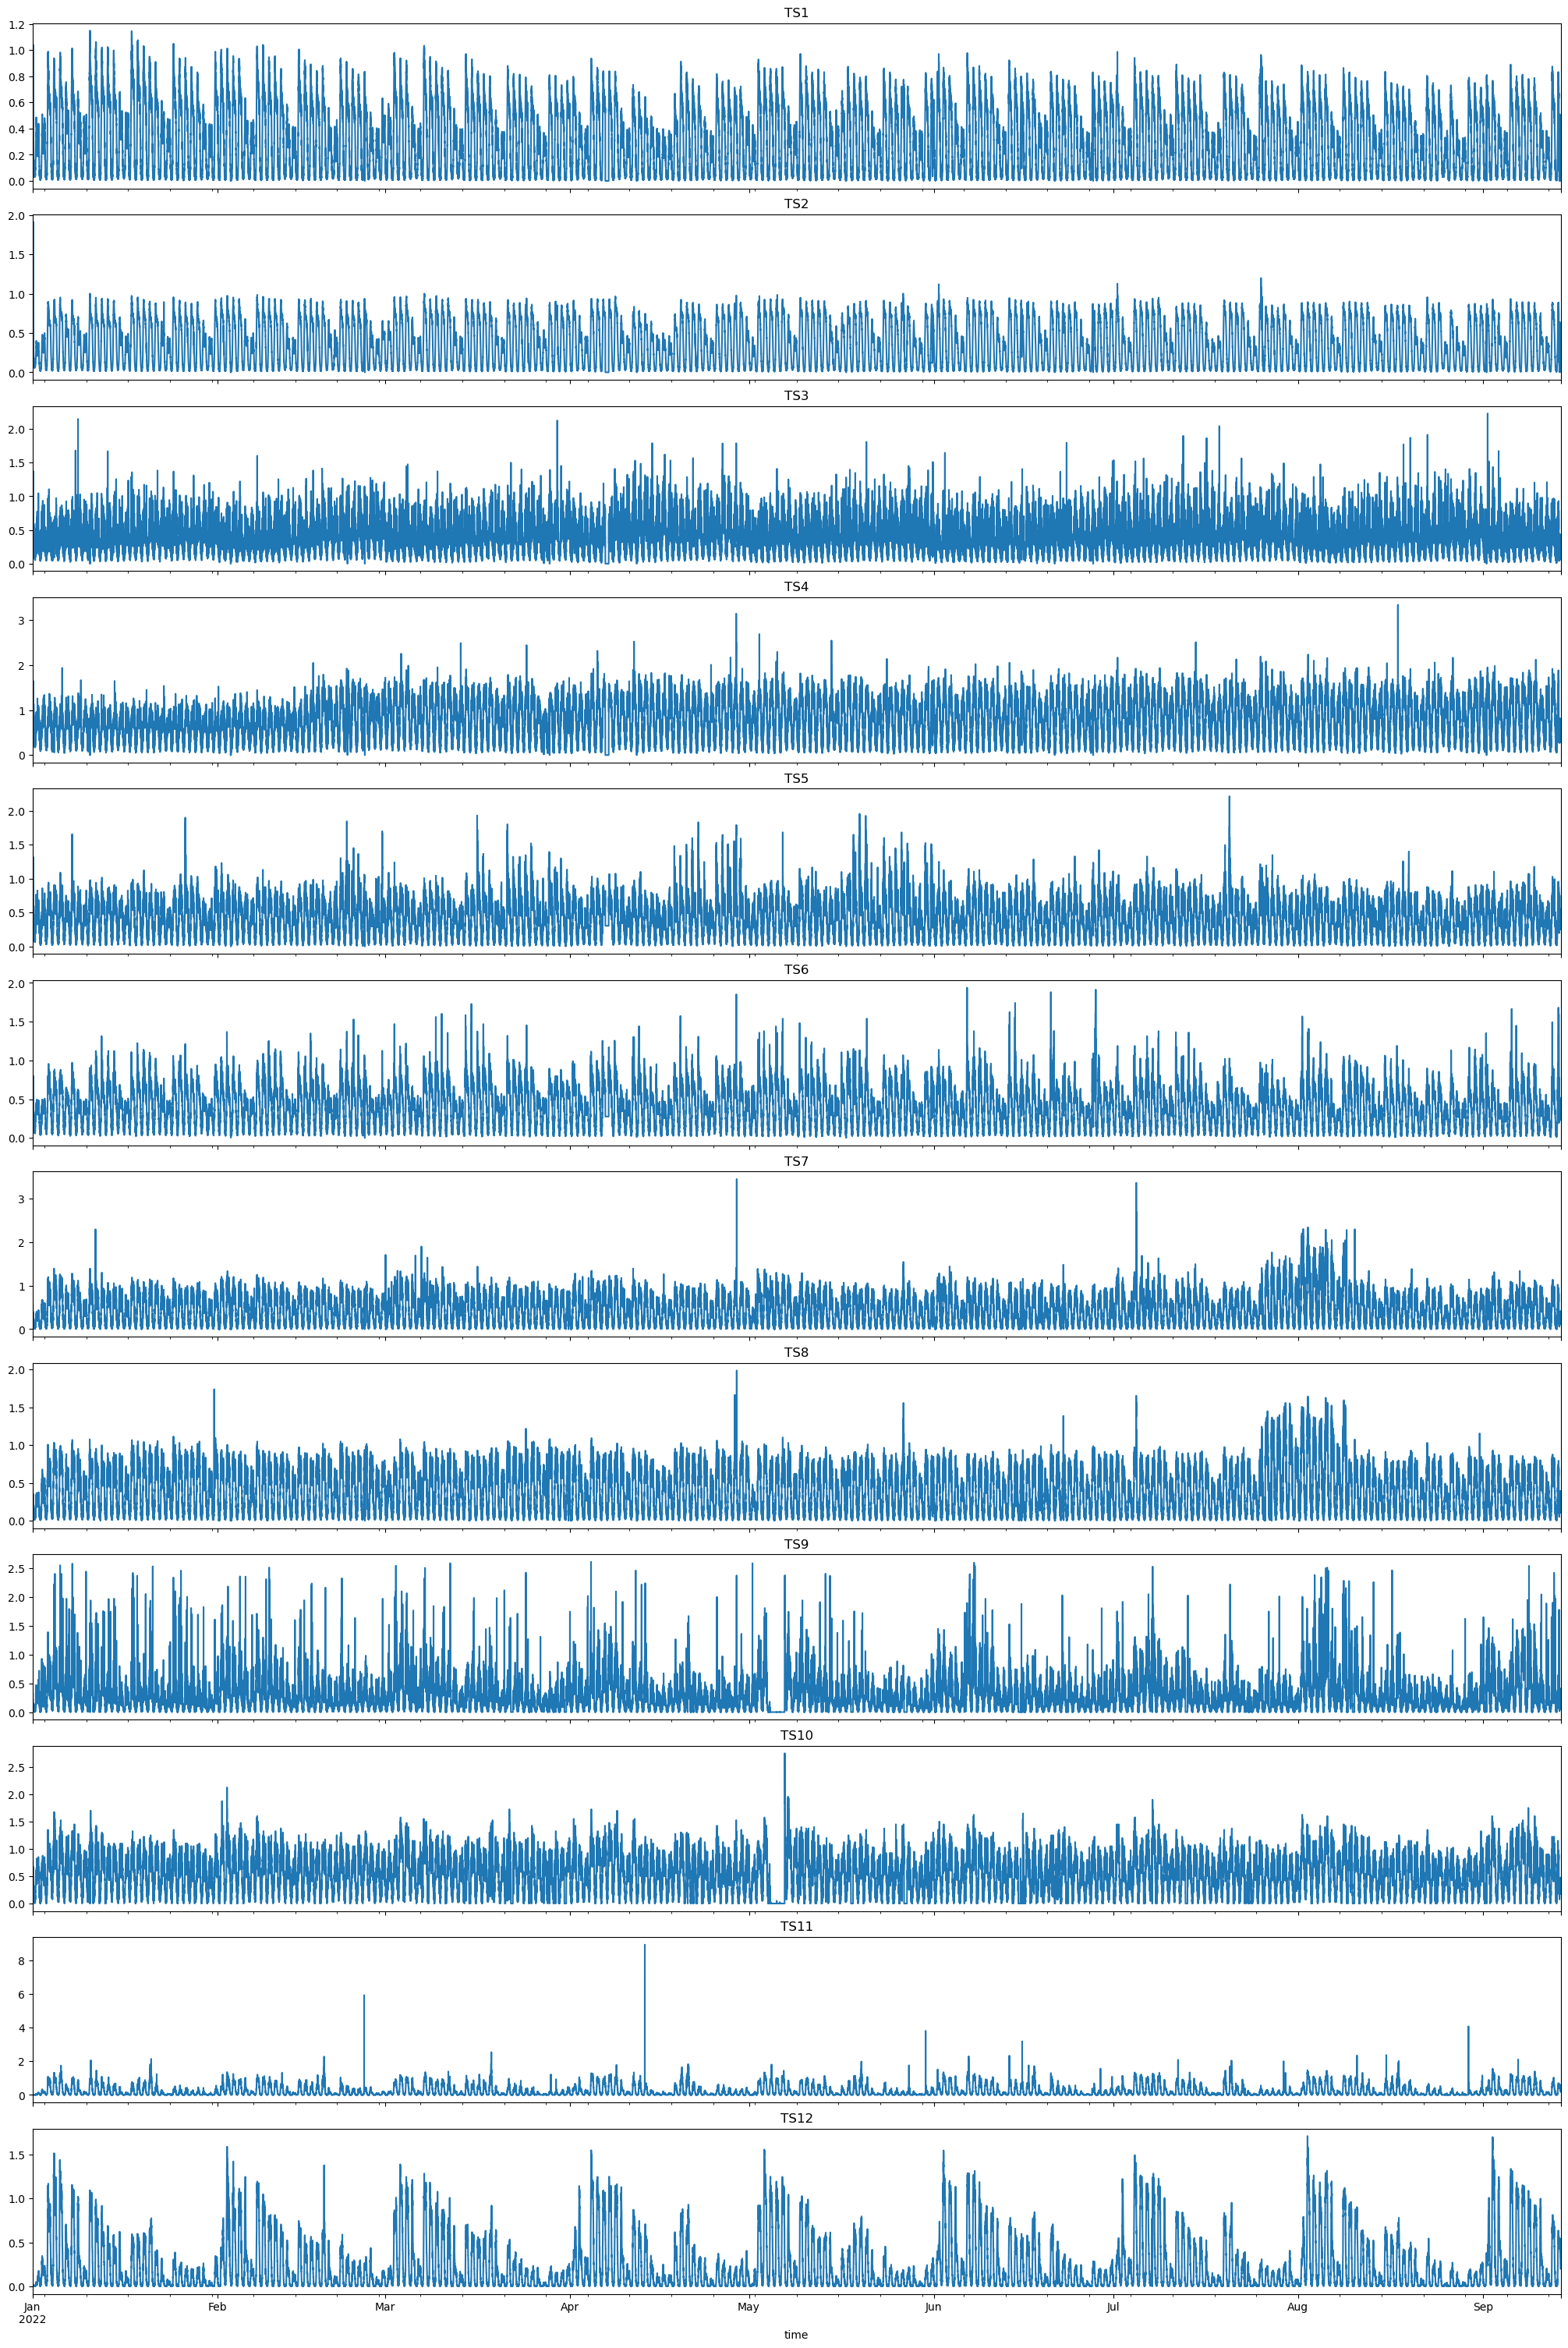

In [7]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data.columns

time_start = '2022-01-01'
time_end = '2022-09-13'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

### Tada por task

In [8]:
data_train_task1 = data[:'2022-02-28']
data_test_task1 = data['2022-03-01':'2022-03-31']

data_train_task2 = data['2022-04-01':'2022-05-31']
data_test_task2 = data['2022-06-01':'2022-06-30']

data_train_task3 = data['2022-07-01':'2022-08-31']
data_test_task3 = data['2022-09-01':'2022-09-12']

<AxesSubplot:>

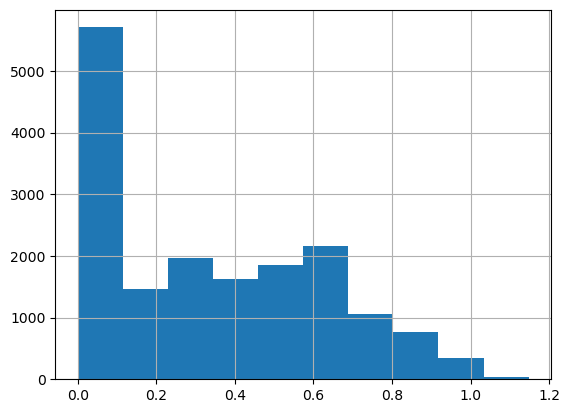

In [9]:
data_train_task1['TS1'].hist()

<AxesSubplot:xlabel='time'>

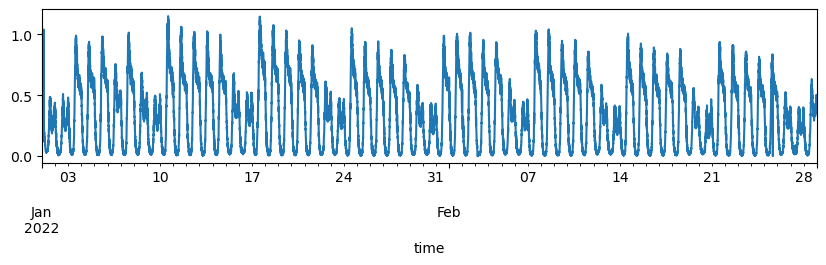

In [10]:
plt.figure(figsize=[10,2])
data_train_task1['TS1'].plot()

### CD

In [11]:
columns = ['TS1']

for col in columns:
    data_train_task1[col] =  3 * (data_train_task1[col])/4
    data_test_task1[col] = 3 * (data_test_task1[col])/4

    data_train_task2[col] = 2 * (data_train_task2[col])/4 
    data_test_task2[col] = 2 * (data_test_task2[col])/4  

    data_train_task3[col] =  (data_train_task3[col])/4  
    data_test_task3[col] = (data_test_task3[col])/4  

/tmp/ipykernel_639375/720588565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_task1[col] =  3 * (data_train_task1[col])/4
/tmp/ipykernel_639375/720588565.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_task1[col] = 3 * (data_test_task1[col])/4
/tmp/ipykernel_639375/720588565.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

<AxesSubplot:>

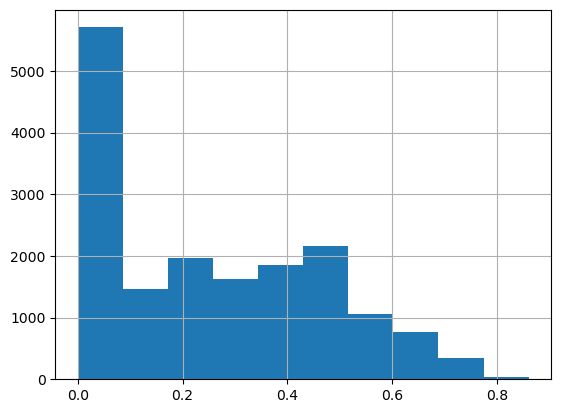

In [12]:
data_train_task1['TS1'].hist()

<AxesSubplot:xlabel='time'>

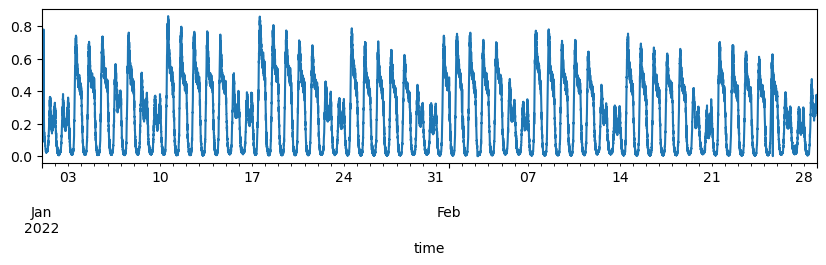

In [13]:
plt.figure(figsize=[10,2])
data_train_task1['TS1'].plot()

In [14]:
TS1_CD = pd.concat([data_train['TS1'], data_train_task1['TS1'], data_test_task1['TS1'], data_train_task2['TS1'], data_test_task2['TS1'], 
    data_train_task3['TS1'], data_test_task3['TS1']])

<AxesSubplot:xlabel='time'>

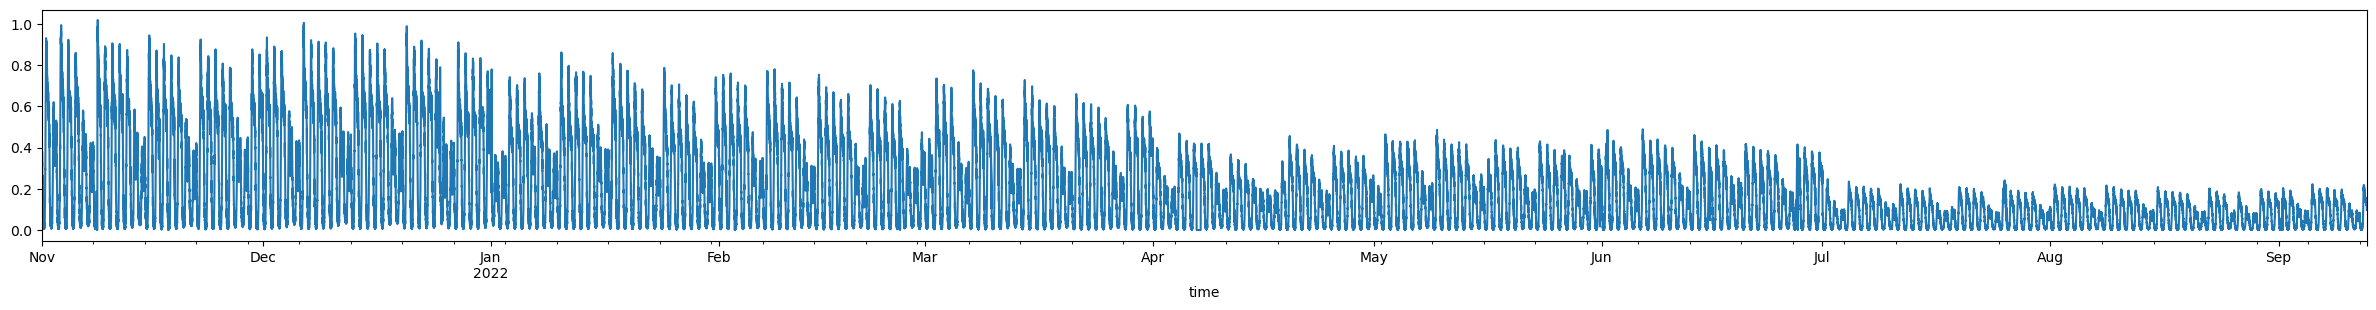

In [15]:
plt.figure(figsize=[30, 3])
TS1_CD.plot()

## Task1

In [16]:
# Model initialization
model_task1 = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

model_task1.vae = keras.models.load_model(settings['model_name']+'_complete.h5',
                                        custom_objects={'sampling': Sampling},
                                        compile = True)

# Compilation
opt = optimizers.Adam(learning_rate=settings['lr'])
#opt = optimizers.SGD(learning_rate=0.1*settings['lr'], momentum=0.9)
model_task1.vae.compile(optimizer=opt)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-06-17 19:41:53.025801: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-17 19:41:53.026551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-17 19:41:53.042925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 19:41:53.043162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-06-17 19:41:53.043179: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-17 19:41:53.044280: I tensorflow/stream_executor/platform/default/d

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [17]:
noise = np.random.normal(0, 0.1, (3*(data_train.shape[0]//10), 1, settings['J']))

decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
                                                custom_objects={'sampling': Sampling},
                                                compile = True)

mu_gen_task0, log_var_gen_task0 = decoder.predict(noise)

sig_gen_task0 = np.sqrt(np.exp(log_var_gen_task0))
noise2gen = np.random.normal(0, 1, (mu_gen_task0.shape[0], settings['T'], settings['M']))
X_gen_task0 = mu_gen_task0 + noise2gen*(sig_gen_task0)
X_gen_task0 = np.where(X_gen_task0 > 0, X_gen_task0, 0)                              

2023-06-17 19:41:54.297116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-17 19:41:54.297451: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2023-06-17 19:41:54.406096: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-17 19:41:54.881097: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-17 19:41:54.955588: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-06-17 19:41:55.660099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [18]:
model_task1.fit(data_train_task1,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_GR_task1',
    settings['save_best_model'],
    False,
    X_gen_task0)

Epoch 1/200
554/554 [==============================] - 67s 79ms/step - loss: -1.8394 - reconst: -1.9824 - kl: 0.0051 - val_loss: -2.0196 - val_reconst: -2.0197 - val_kl: 1.6294e-04
Epoch 2/200
554/554 [==============================] - 8s 14ms/step - loss: -2.0522 - reconst: -2.0600 - kl: 1.0727e-04 - val_loss: -2.0519 - val_reconst: -2.0520 - val_kl: 7.2980e-05
Epoch 3/200
554/554 [==============================] - 8s 14ms/step - loss: -2.0677 - reconst: -2.0710 - kl: 5.6796e-05 - val_loss: -2.0692 - val_reconst: -2.0692 - val_kl: 5.5694e-05
Epoch 4/200
554/554 [==============================] - 8s 14ms/step - loss: -2.0766 - reconst: -2.0723 - kl: 3.7925e-05 - val_loss: -2.0478 - val_reconst: -2.0478 - val_kl: 3.8247e-05
Epoch 5/200
554/554 [==============================] - 8s 14ms/step - loss: -2.0883 - reconst: -2.0869 - kl: 2.6713e-05 - val_loss: -2.0811 - val_reconst: -2.0812 - val_kl: 2.1886e-05
Epoch 6/200
554/554 [==============================] - 8s 14ms/step - loss: -2.0940

### Data 0 Task 1

In [19]:
_, _, reconst_data0_task1, sig_data0_task1, _ = model_task1.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task1'
                                                    )

<AxesSubplot:>

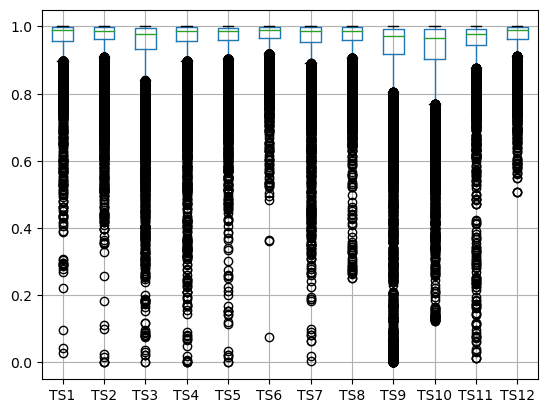

In [20]:
likelihood_data0_task1 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task1, sig_data0_task1)
likelihood_data0_task1.boxplot()

(0.8, 1.02)

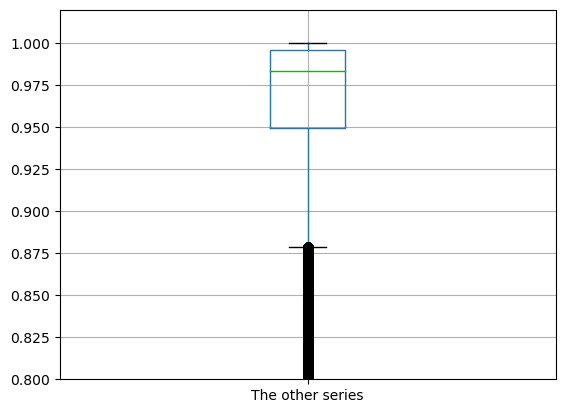

In [21]:
likelihood_data0_task1_rest = pd.concat([likelihood_data0_task1[col] for col in likelihood_data0_task1.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task1_rest = pd.DataFrame(likelihood_data0_task1_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task1_rest.boxplot()
plt.ylim([0.80, 1.02])

<AxesSubplot:>

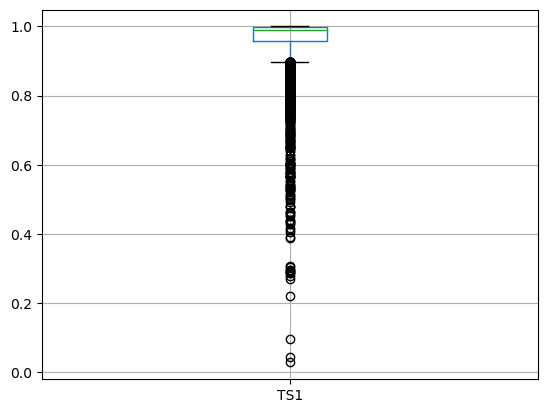

In [22]:
likelihood_data0_task1.boxplot(column=['TS1'])

### Data 1 Task 1

In [23]:
_, _, reconst_data1_task1, sig_data1_task1, _ = model_task1.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task1'
                                                    )

<AxesSubplot:>

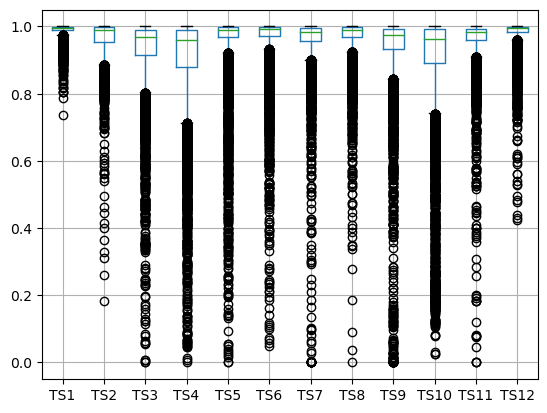

In [24]:
likelihood_data1_task1 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task1, sig_data1_task1)
likelihood_data1_task1.boxplot()

(0.8, 1.02)

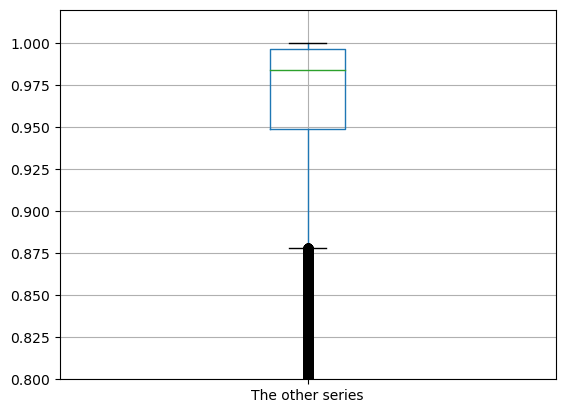

In [25]:
likelihood_data1_task1_rest = pd.concat([likelihood_data1_task1[col] for col in likelihood_data1_task1.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task1_rest = pd.DataFrame(likelihood_data1_task1_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task1_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7fe521585b20>,
 [Text(1, 0, 'data0_task1'), Text(2, 0, 'data1_task1')])

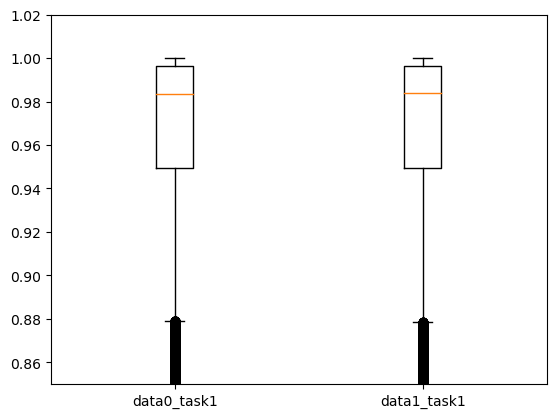

In [26]:
plt.boxplot([likelihood_data0_task1_rest.values[:,0], likelihood_data1_task1_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2], ['data0_task1', 'data1_task1'])

## Task 2

In [27]:
# Model initialization
model_task2 = DCVAE(
     settings['T'],
     settings['M'],
     settings['cnn_units'],
     settings['dil_rate'],
     settings['kernel'],
     settings['strs'],
     settings['batch_size'],
     settings['J'],
     settings['lr'],
     settings['lr_decay'],
     settings['decay_rate'],
     settings['decay_step'],
     settings['time_embedding'],
     settings['summary'],
     ) 

#model_task2.vae = keras.models.load_model(settings['model_name']+'_task1'+'_complete.h5',
#                                        custom_objects={'sampling': Sampling},
#                                        compile = True)
model_task2.vae = clone_model(model_task1.vae)

# Compilation
opt = optimizers.Adam(learning_rate=settings['lr'])
#opt = optimizers.SGD(learning_rate=0.1*settings['lr'], momentum=0.9)
model_task2.vae.compile(optimizer=opt)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [28]:
noise = np.random.normal(0, 0.1, (3*(data_train.shape[0]//10), 1, settings['J']))

#decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
#                                                custom_objects={'sampling': Sampling},
#                                                compile = True)


mu_gen_task1, log_var_gen_task1 = model_task1.decoder.predict(noise)

sig_gen_task1 = np.sqrt(np.exp(log_var_gen_task1))
noise2gen = np.random.normal(0, 1, (mu_gen_task1.shape[0], settings['T'], settings['M']))
X_gen_task1 = mu_gen_task1 + noise2gen*(sig_gen_task1)
X_gen_task1 = np.where(X_gen_task1 > 0, X_gen_task1, 0)   

In [29]:
model_task2.fit(data_train_task2,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_GR_task2',
    settings['save_best_model'],
    False,
    X_gen_task1)

Epoch 1/200
568/568 [==============================] - 52s 90ms/step - loss: 2.6710 - reconst: 1.0566 - kl: 0.0429 - val_loss: 0.1604 - val_reconst: 0.1533 - val_kl: 0.0072
Epoch 2/200
568/568 [==============================] - 8s 15ms/step - loss: -0.0117 - reconst: -0.1406 - kl: 0.0045 - val_loss: -0.3092 - val_reconst: -0.3122 - val_kl: 0.0029
Epoch 3/200
568/568 [==============================] - 8s 14ms/step - loss: -0.3796 - reconst: -0.4570 - kl: 0.0022 - val_loss: -0.6088 - val_reconst: -0.6105 - val_kl: 0.0017
Epoch 4/200
568/568 [==============================] - 8s 15ms/step - loss: -0.6895 - reconst: -0.7585 - kl: 0.0013 - val_loss: -0.8828 - val_reconst: -0.8838 - val_kl: 9.9487e-04
Epoch 5/200
568/568 [==============================] - 8s 15ms/step - loss: -0.9345 - reconst: -0.9806 - kl: 7.4920e-04 - val_loss: -1.0623 - val_reconst: -1.0629 - val_kl: 5.8847e-04
Epoch 6/200
568/568 [==============================] - 8s 15ms/step - loss: -1.0843 - reconst: -1.1139 - kl: 4.

### Data 0 Task 2

In [30]:
_, _, reconst_data0_task2, sig_data0_task2, _ = model_task2.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

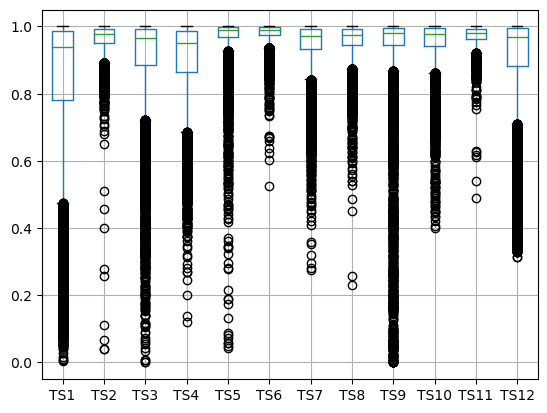

In [31]:
likelihood_data0_task2 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task2, sig_data0_task2)
likelihood_data0_task2.boxplot()

(0.8, 1.02)

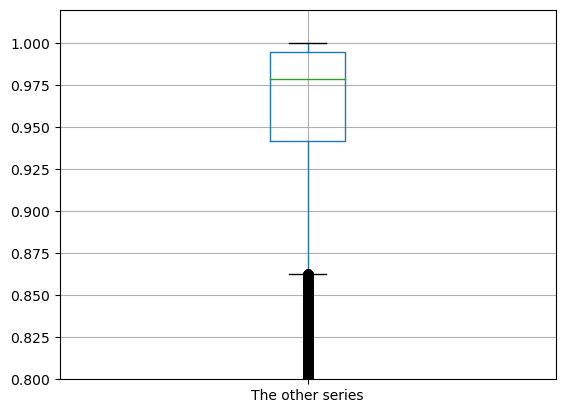

In [32]:
likelihood_data0_task2_rest = pd.concat([likelihood_data0_task2[col] for col in likelihood_data0_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task2_rest = pd.DataFrame(likelihood_data0_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 1 Task 2

In [33]:
_, _, reconst_data1_task2, sig_data1_task2, _ = model_task2.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

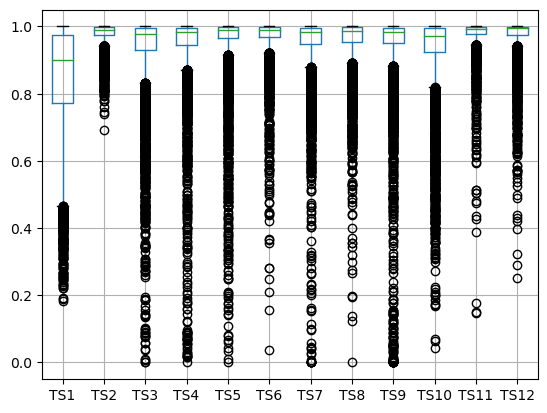

In [34]:
likelihood_data1_task2 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task2, sig_data1_task2)
likelihood_data1_task2.boxplot()

(0.8, 1.02)

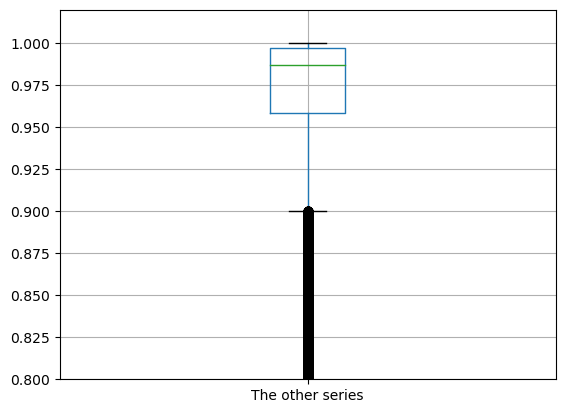

In [35]:
likelihood_data1_task2_rest = pd.concat([likelihood_data1_task2[col] for col in likelihood_data1_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task2_rest = pd.DataFrame(likelihood_data1_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 2 Task 2

In [36]:
_, _, reconst_data2_task2, sig_data2_task2, _ = model_task2.predict(data_test_task2,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

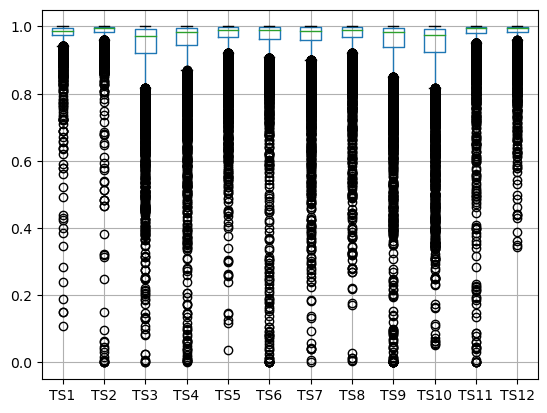

In [37]:
likelihood_data2_task2 = likelihood_norm(data_test_task2[settings['T']-1:], reconst_data2_task2, sig_data2_task2)
likelihood_data2_task2.boxplot()

(0.8, 1.02)

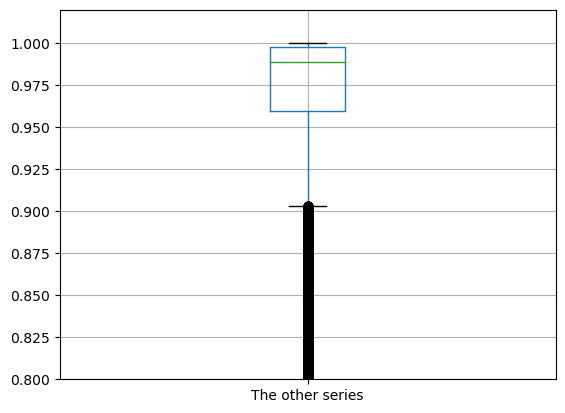

In [38]:
likelihood_data2_task2_rest = pd.concat([likelihood_data2_task2[col] for col in likelihood_data2_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data2_task2_rest = pd.DataFrame(likelihood_data2_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data2_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7fe498310f40>,
 [Text(1, 0, 'data0_task2'),
  Text(2, 0, 'data1_task2'),
  Text(3, 0, 'data2_task2')])

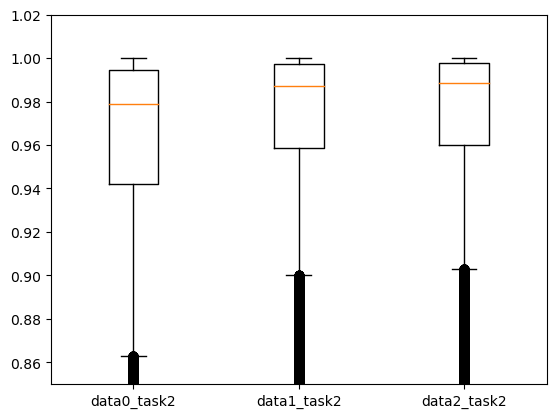

In [39]:
plt.boxplot([likelihood_data0_task2_rest.values[:,0], likelihood_data1_task2_rest.values[:,0], likelihood_data2_task2_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3], ['data0_task2', 'data1_task2', 'data2_task2'])

([<matplotlib.axis.XTick at 0x7fe49829d640>,
 [Text(1, 0, 'data0_task2'),
  Text(2, 0, 'data1_task2'),
  Text(3, 0, 'data2_task2')])

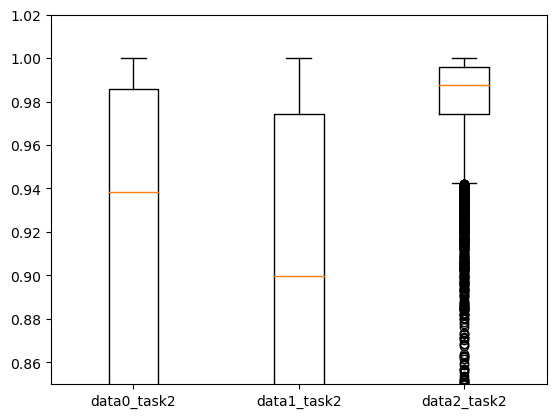

In [40]:
plt.boxplot([likelihood_data0_task2['TS1'].values, likelihood_data1_task2['TS1'].values, likelihood_data2_task2['TS1'].values])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3], ['data0_task2', 'data1_task2', 'data2_task2'])

## Task 3

In [41]:
# Model initialization
model_task3 = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

#model_task3.vae = keras.models.load_model(settings['model_name']+'_task2'+'_complete.h5',
#                                        custom_objects={'sampling': Sampling},
#                                        compile = True)

model_task3.vae = clone_model(model_task2.vae)


# Compilation
opt = optimizers.Adam(learning_rate=settings['lr'])
#opt = optimizers.SGD(learning_rate=0.1*settings['lr'], momentum=0.9)
model_task3.vae.compile(optimizer=opt)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [42]:
noise = np.random.normal(0, 0.1, (3*(data_train.shape[0]//10), 1, settings['J']))

#decoder = keras.models.load_model(settings['model_name']+'_decoder.h5',
#                                                custom_objects={'sampling': Sampling},
#                                                compile = True)


mu_gen_task2, log_var_gen_task2 = model_task2.decoder.predict(noise)

sig_gen_task2 = np.sqrt(np.exp(log_var_gen_task2))
noise2gen = np.random.normal(0, 1, (mu_gen_task2.shape[0], settings['T'], settings['M']))
X_gen_task2 = mu_gen_task2 + noise2gen*(sig_gen_task2)
X_gen_task2 = np.where(X_gen_task2 > 0, X_gen_task2, 0)   

In [43]:
model_task3.fit(data_train_task3,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_GR_task3',
    settings['save_best_model'],
    False,
    X_gen_task2)

Epoch 1/200
575/575 [==============================] - 59s 100ms/step - loss: 0.7696 - reconst: 0.0229 - kl: 0.0414 - val_loss: -0.6757 - val_reconst: -0.6815 - val_kl: 0.0058
Epoch 2/200
575/575 [==============================] - 8s 15ms/step - loss: -0.8428 - reconst: -0.9579 - kl: 0.0034 - val_loss: -1.1447 - val_reconst: -1.1469 - val_kl: 0.0022
Epoch 3/200
575/575 [==============================] - 8s 15ms/step - loss: -1.1753 - reconst: -1.2109 - kl: 0.0016 - val_loss: -1.2426 - val_reconst: -1.2438 - val_kl: 0.0013
Epoch 4/200
575/575 [==============================] - 8s 15ms/step - loss: -1.2899 - reconst: -1.3102 - kl: 0.0010 - val_loss: -1.3657 - val_reconst: -1.3665 - val_kl: 8.4893e-04
Epoch 5/200
575/575 [==============================] - 8s 14ms/step - loss: -1.3838 - reconst: -1.3958 - kl: 7.0009e-04 - val_loss: -1.4585 - val_reconst: -1.4591 - val_kl: 5.7798e-04
Epoch 6/200
575/575 [==============================] - 8s 14ms/step - loss: -1.4318 - reconst: -1.4453 - kl:

### Data 0 Task 3

In [44]:
_, _, reconst_data0_task3, sig_data0_task3, _ = model_task3.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

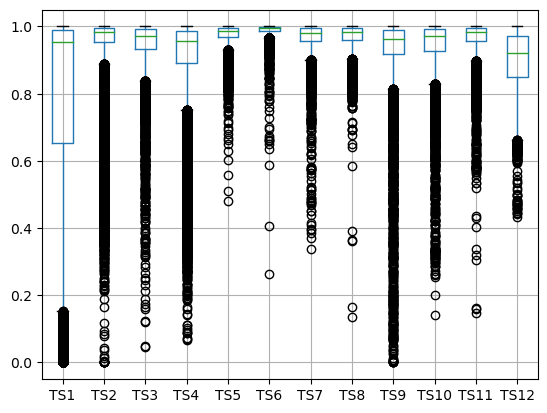

In [45]:
likelihood_data0_task3 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task3, sig_data0_task3)
likelihood_data0_task3.boxplot()

(0.8, 1.02)

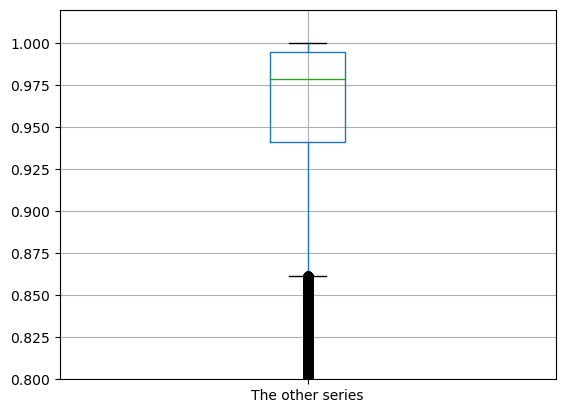

In [46]:
likelihood_data0_task3_rest = pd.concat([likelihood_data0_task3[col] for col in likelihood_data0_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task3_rest = pd.DataFrame(likelihood_data0_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 1 Task 3

In [47]:
_, _, reconst_data1_task3, sig_data1_task3, _ = model_task3.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

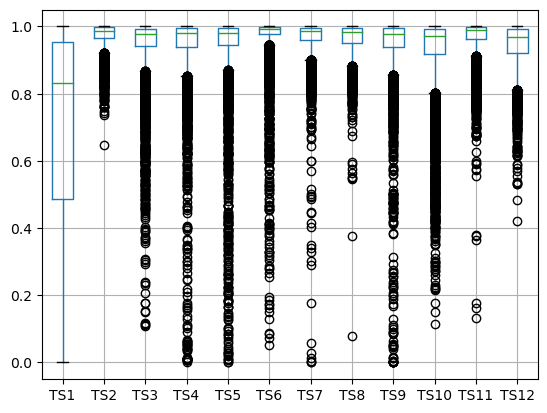

In [48]:
likelihood_data1_task3 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task3, sig_data1_task3)
likelihood_data1_task3.boxplot()

(0.8, 1.02)

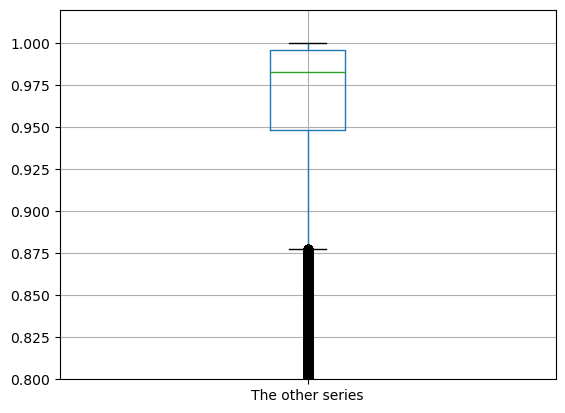

In [49]:
likelihood_data1_task3_rest = pd.concat([likelihood_data1_task3[col] for col in likelihood_data1_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task3_rest = pd.DataFrame(likelihood_data1_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 2 Task 3

In [50]:
_, _, reconst_data2_task3, sig_data2_task3, _ = model_task3.predict(data_test_task2,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

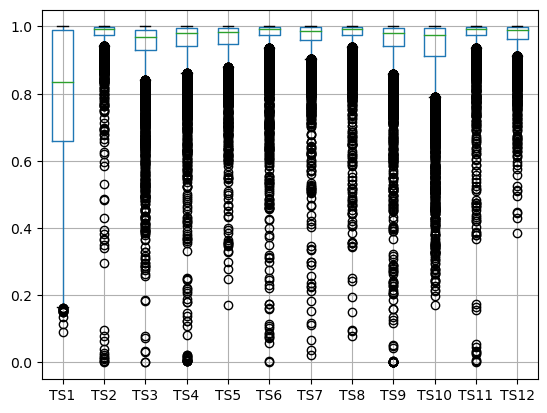

In [51]:
likelihood_data2_task3 = likelihood_norm(data_test_task2[settings['T']-1:], reconst_data2_task3, sig_data2_task3)
likelihood_data2_task3.boxplot()

(0.8, 1.02)

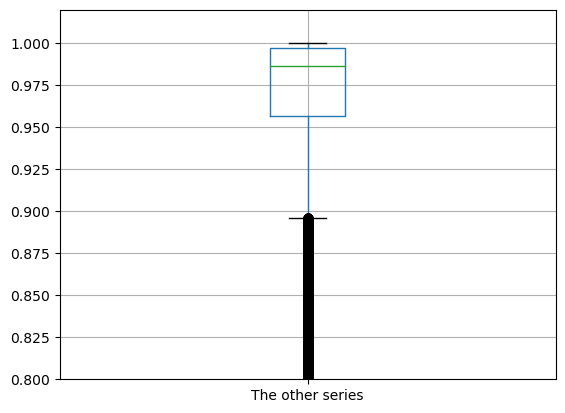

In [52]:
likelihood_data2_task3_rest = pd.concat([likelihood_data2_task3[col] for col in likelihood_data2_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data2_task3_rest = pd.DataFrame(likelihood_data2_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data2_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 3 Task 3

In [53]:
_, _, reconst_data3_task3, sig_data3_task3, _ = model_task3.predict(data_test_task3,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

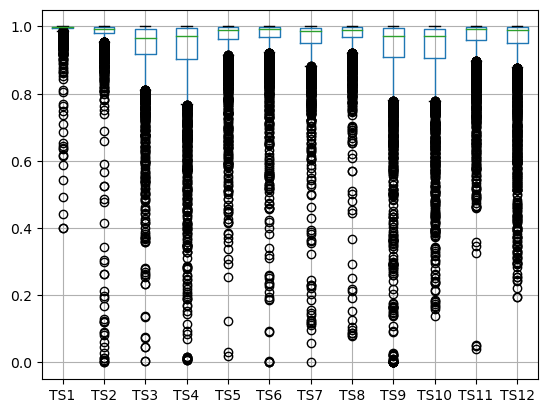

In [54]:
likelihood_data3_task3 = likelihood_norm(data_test_task3[settings['T']-1:], reconst_data3_task3, sig_data3_task3)
likelihood_data3_task3.boxplot()

(0.8, 1.02)

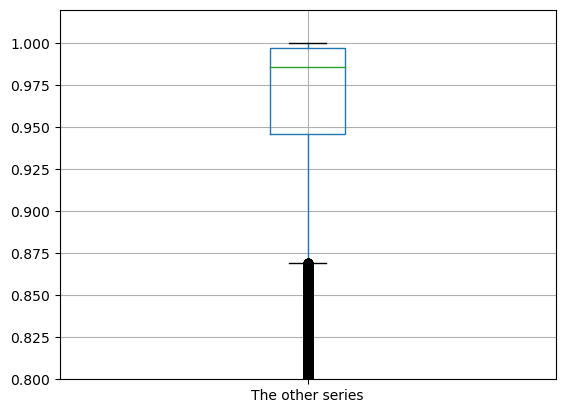

In [55]:
likelihood_data3_task3_rest = pd.concat([likelihood_data3_task3[col] for col in likelihood_data3_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data3_task3_rest = pd.DataFrame(likelihood_data3_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data3_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7fe1ac094b50>,
 [Text(1, 0, 'data0_task3'),
  Text(2, 0, 'data1_task3'),
  Text(3, 0, 'data2_task3'),
  Text(4, 0, 'data3_task3')])

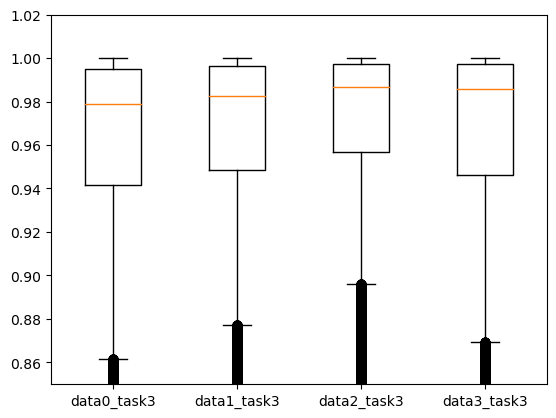

In [56]:
plt.boxplot([likelihood_data0_task3_rest.values[:,0], likelihood_data1_task3_rest.values[:,0], likelihood_data2_task3_rest.values[:,0], likelihood_data3_task3_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3, 4], ['data0_task3', 'data1_task3', 'data2_task3', 'data3_task3'])

([<matplotlib.axis.XTick at 0x7fe498514070>,
 [Text(1, 0, 'data0_task3'),
  Text(2, 0, 'data1_task3'),
  Text(3, 0, 'data2_task3'),
  Text(4, 0, 'data3_task3')])

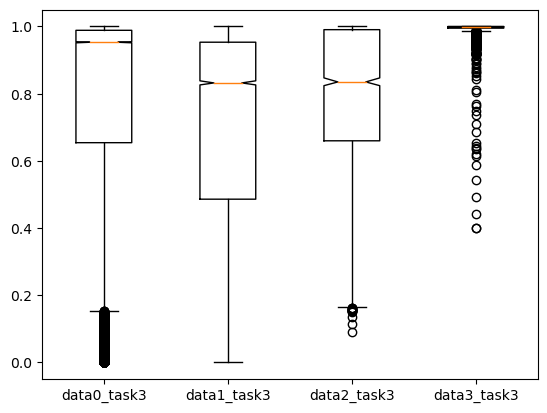

In [57]:
plt.boxplot([likelihood_data0_task3['TS1'].values, likelihood_data1_task3['TS1'].values, likelihood_data2_task3['TS1'].values, likelihood_data3_task3['TS1'].values],
 notch=True,
 bootstrap=5000)
plt.title('')
plt.xticks([1, 2, 3, 4], ['data0_task3', 'data1_task3', 'data2_task3', 'data3_task3'])

In [58]:
likelihood_data0_task3['TS1'].shape

(17441,)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe4fc2d53d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe4fc2d5a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe4fc0e4850>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4fc2d5790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4fc2e4880>],
 'means': []}

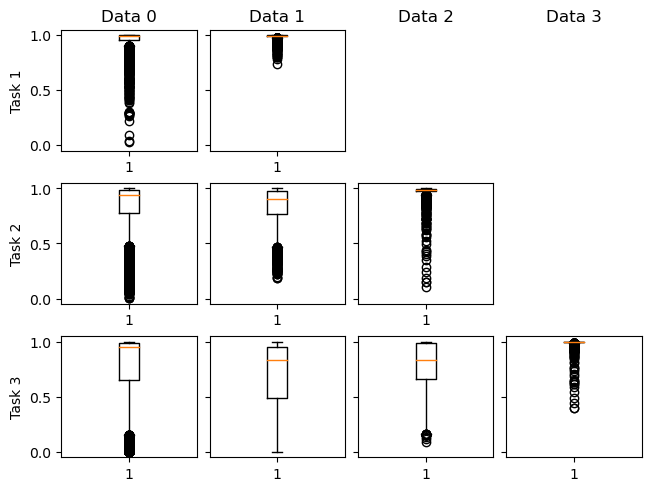

In [59]:
#define number of rows and columns for subplots
nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, constrained_layout=True, sharey=True)

axes[0,0].boxplot(likelihood_data0_task1['TS1'].values)
axes[0,0].set_title('Data 0')
axes[0,0].set_ylabel('Task 1')
axes[0,1].boxplot(likelihood_data1_task1['TS1'].values)
axes[0,1].set_title('Data 1')
axes[0,2].axis('off')
axes[0,2].set_title('Data 2')
axes[0,3].axis('off')
axes[0,3].set_title('Data 3')


axes[1,0].boxplot(likelihood_data0_task2['TS1'].values)
axes[1,0].set_ylabel('Task 2')
axes[1,1].boxplot(likelihood_data1_task2['TS1'].values)
axes[1,2].boxplot(likelihood_data2_task2['TS1'].values)
axes[1,3].axis('off')

axes[2,0].boxplot(likelihood_data0_task3['TS1'].values)
axes[2,0].set_ylabel('Task 3')
axes[2,1].boxplot(likelihood_data1_task3['TS1'].values)
axes[2,2].boxplot(likelihood_data2_task3['TS1'].values)
axes[2,3].boxplot(likelihood_data3_task3['TS1'].values)


(0.8, 1.02)

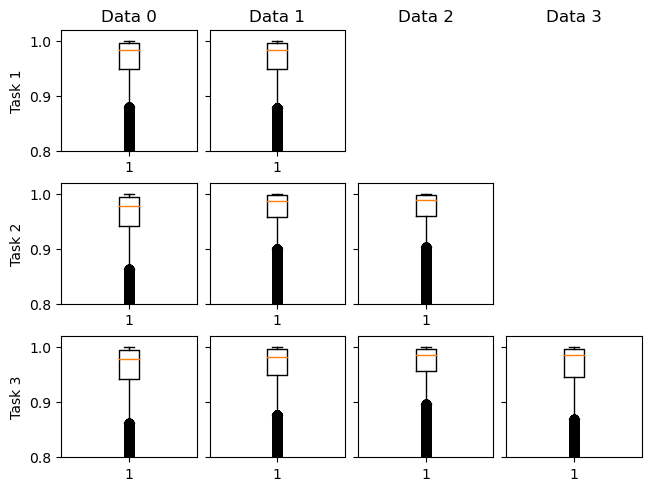

In [60]:
#define number of rows and columns for subplots
nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, constrained_layout=True, sharey=True)

axes[0,0].boxplot(likelihood_data0_task1_rest.values[:,0])
axes[0,0].set_title('Data 0')
axes[0,0].set_ylabel('Task 1')
axes[0,1].boxplot(likelihood_data1_task1_rest.values[:,0])
axes[0,1].set_title('Data 1')
axes[0,2].axis('off')
axes[0,2].set_title('Data 2')
axes[0,3].axis('off')
axes[0,3].set_title('Data 3')


axes[1,0].boxplot(likelihood_data0_task2_rest.values[:,0])
axes[1,0].set_ylabel('Task 2')
axes[1,1].boxplot(likelihood_data1_task2_rest.values[:,0])
axes[1,2].boxplot(likelihood_data2_task2_rest.values[:,0])
axes[1,3].axis('off')

axes[2,0].boxplot(likelihood_data0_task3_rest.values[:,0])
axes[2,0].set_ylabel('Task 3')
axes[2,1].boxplot(likelihood_data1_task3_rest.values[:,0])
axes[2,2].boxplot(likelihood_data2_task3_rest.values[:,0])
axes[2,3].boxplot(likelihood_data3_task3_rest.values[:,0])

plt.ylim([0.80, 1.02])
